In [1]:
%run Latex_macros.ipynb
%run beautify_plots.py

<IPython.core.display.Latex object>

In [2]:
# My standard magic !  You will see this in almost all my notebooks.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

%matplotlib inline

In [3]:
%run beautify_plots.py

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import neural_net_helper
%aimport neural_net_helper

nnh = neural_net_helper.NN_Helper()

import decision_trees_helper
%aimport decision_trees_helper

bh  = decision_trees_helper.Boundary_Helper()


# From where do Neural Networks derive their power ?

Neural Networks seem to be more powerful than the models obtained from Classical Machine Learning.

Why might that be ?

To be concrete: let us consider the Classification task.


A Classifier can be viewed as creating a decision boundary
- regions within feature space (e.g., $\mathbb{R}^n$) in which all examples have the same Class.

For example, a linear classifier like Logistic Regression creates linear boundaries

<img src='images/class_overview_prob_lines.jpg'>

The boundaries of Decision Trees are more complex, but are perpendicular to one feature axis
- due to the nature of the question that labels a node $\node{n}$ of the tree
$$
\x^\ip_j < t_{\node{n},j}
$$

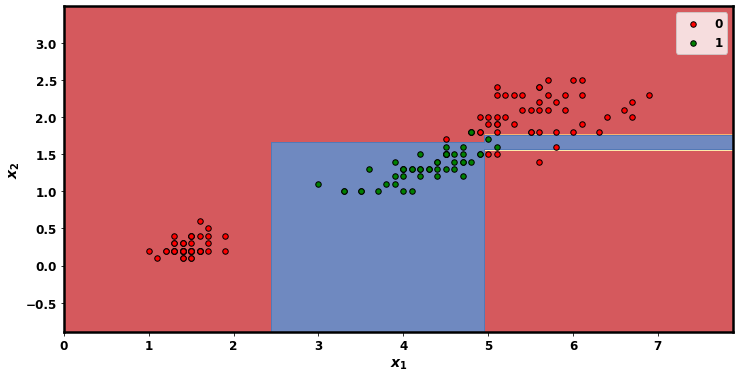

In [5]:
X_2c, y_2c = bh.make_iris_2class()

fig, ax = plt.subplots(figsize=(12,6))
_= bh.make_boundary(X_2c, y_2c, depth=4, ax=ax)

As we will see: 
- the shape of decision boundaries (and functions, for Regression tasks) created by Neural Networks can be much more complex
- the complexity is obtained due to the non-linear activation functions

# The power of non-linear activation functions

In our introduction to Neural Networks, we identified non-linear activation functions as a key ingredient.

Let's examine, in depth, why this is so.

Many activation functions behave like a binary "switch"
- Converting the scalar value computed by the dot product
- Into a True/False answer
- To the question: "Is a particular feature present" ?

By changing the "bias" from $0$, we can move the threshold of the switch to an arbitrary value.

This allows us to construct a *piece-wise* approximation of a function
- The switch, in the region in which it is active, defines one piece
- Changing the bias/threshold allows us to relocate the piece

Consider the following function $f$:

<div>
    <br>
    <center><strong>Function to approximate</strong></center>
    <br>
<img src=images/W9_L0_S5_Piecewise_linear_1.png width = "80%">
    <!-- edX: Original: <img src="images/Piecewise_linear_1.jpg"> replace by EdX created image --> 
</div>

This function is
- Not continuous
- Define over set of discrete examples

$$ \langle \X, \y \rangle= [ \x^\ip, \y^\ip | 1 \le i \le m ]$$

For ease of presentation, we will assume the examples are sorted in increasing value of $\x^\ip$:
$$
\x^{(0)} \lt \x^{(1)} \lt \ldots \x^{(m)}
$$

<div>
    <center><strong>Function to approximate, defined by examples <b>x</b></strong></center>
    <br>
<img src=images/W9_L0_S7_Piecewise_linear.png width = "80%">
    <!-- edX: Original: <img src="images/Piecewise_linear.jpg"> replace by EdX created image --> >
</div>

We can replicate the discrete function
- By a sequence of *step functions*
- Which create a piece-wise approximation of the function $f$

<div>
    <br>
    <center><strong>Piece-wise function approximation by step functions</strong></center>
    <br>
<img src=images/W9_L0_S9_Piecewise_linear.png width="80%">
</div>

We will show how to construct a Step Function using 
- ReLU activation with $0$ threshold

Once we have a step, we can place the center of the step anywhere along the $\x$ axis
- By adjusting the threshold of the ReLU

We start off by constructing a binary switch
(output of a ReLU with constant input equal to $1$) whose output is either $0$ or $1$
<br>
<br>
<div>
    <center><strong>Step function: binary switch with threshold 0</strong></center>
    <br>
<img src=images/Step_function_1.jpg width=70%>
</div>

We can re-center the binary switch from activating at $\x = 0$ to activating at $\x = \x^\ip$
- by adjusting the bias of the ReLU to $- \x^\ip$
<br>
<br>
<div>
    <center><strong>Step function: binary switch with threshold - x^(i)</strong></center>
    <br>
<img src=images/Step_function_2.jpg>
</div>

By adding an inverted step function (step function with negative weight) that becomes active at $\x = \x^{(i +1)}$
- we can create an impulse function that is non-zero in the range $\x^\ip \le \x \le \x^{(i+1)}$

<br>
<br>
<div>
    <center><strong>Impulse function: Center x^(i); width (x^(i+1) - x^(i))</strong></center>
    <br>
<img src=images/Step_function_3.jpg>
</div>

Note that both the Binary Switch and the Impulse (step) function are created using noting more than a ReLU.

We will create $m$ Binary Switches, one for each $1 \le i \le m$ example $\x^\ip$.

We will pair the Binary Switch with a neuron (Fully connected network with one input and one output)
- that scales the output to $\x^\ip$.

By careful arrangement of the Binary Switches, we will create a NN computes a function that
- exactly replicates the empirical $f(\x)$
- has a continuous domain
    - outputs a value for all $\x$, not just $\x \in \X$





That's the idea at a very intuitive level.

The rest of the notebook demonstrates exactly how to achieve this.

# Universal function approximator
A Neural Network is a Universal Function Approximator.

This means that an NN that is sufficiently 
- wide (large number of neurons per layer) 
- and deep (many layers; deeper means the network can be narrower)

can approximate (to arbitrary degree)
the function represented by the training set.

Recall that the training data $\langle \X, \y \rangle = [ (\x^\ip, \y^\ip) |  1 \le i \le m ]$ is a sequence of input/target pairs.

The training data defines a function empirically (defined only at values $\x \in \X$.

This may look like a strange way to define a function 
- but it is indeed a mapping from the
domain of $\x$ (i.e., $\mathcal{R}^n$) to the domain of $\y$ (i.e., $\mathcal{R})$
- subject to $\y^i = \y^{i'} \;  \text{if} \; \x^i = \x^{i'}$ (i.e., mapping is unique).

We will demonstrate how to construct a Neural Network that exactly computes the empirically-defined function.

For simplicity of presentation
- we demonstrate this for a one-dimensional function
    - all vectors $\x, \y, \W, \b$ are length 1.
- we assume that the training set
is presented in order of increasing value of $\x$, i.e.
$$
\x^{(0)} \lt \x^{(1)} \lt \ldots \x^{(m)}
$$

We will build a NN to compute this empirically defined function.

The NN will consist of $m$ Binary Switches (one per training example)
- Binary Switch $i$ is associated with example $\langle \x^\ip, f(\x^\ip) \rangle$



Here is the Binary Switch $i$ that we will associate with example $i$ having $\x = \x^\ip$
- A Fully Connected network with one unit ("neuron")
- Constant input equal to the value $1$
- Bias equal to $\,- \x^\ip$
- Weight $\W^\ip$ = $(f(\x^{(i+1)})- f(\x^\ip))$
    - The amount by which $f(\x)$ increases between steps is 

Binary Switch $i$ becomes "active" (non-zero output) for $\x \ge \x^\ip$

Binary Switch $i$
- computes
$$
\max{} \left(0, \W^\ip * 1 +  (-  \x^\ip) \right)
$$
- is "active" (non-zero output) only if $\x \ge \x^\ip$
   
<br>
<br>
<div>
    <img src="images/Step_Neuron.png" width=60%>
</div>




Let us construct $m$ Binary Switches, one per training example
- one per example
- bias for Binary Switch $i$ is $\, \, - \x^\ip$
- weights are

$$
\begin{array}[lll] \\
\W^{(1)}& = & \y^{(1)} \\
\W^\ip & = & \y^{(i)} - \y^{(i-1)} \\
\end{array}
$$

We connect all $m$ Binary Switches to a "final" neuron that simply adds the outputs of all $m$ Binary Switches
- $m$ inputs
- all weights equal to $1$
- Bias equal to $0$

<p></p>
<br>
<div>
        <center><strong>Function Approximation by Binary Switches</strong></center>
    <br>
    <br>
        <img src="images/Universal_Function_Switch.png" width="80%">
        <!-- edX: Original: <img src="images/Universal_Function_Step.png"> replace by EdX created image --> 
    <br>
</div>
<p></p>

Consider what happens when we input $\x = \x^\ip$ to this network.
- The only active Binary Switches are those with index at most $i$
- The Final Neuron computes
$$
\begin{array} \\
\sum_{i'=1}^i {\W^{(i')} } & = & 
 \y^{(1)} + \sum_{i'=2}^i { \y^{(i')} - \y^{(i'-1)} } & \text{ definition of } \W^{(i')} \\
 & = & \y^\ip
\end{array}
$$


Thus, our two layer network outputs $\y^\ip$ given input $\x^\ip$.

It also computes a value for **any** $\x$, not just $\x \in \X$.

**Financial analogy:** if we have call options with completely flexible strikes and same expiry,
we can mimic an arbitrary payoff in a similar manner.

# Conclusion
This proof demonstrates that **in theory** a sufficiently large Neural Network can compute any empirically-defined function.

Thus, Neural Networks are very powerful.

Observe that the key to the power is the ability to create "switches"
- which are possible only using non-linear functions (e.g., activations)

This is not to say that **in practice** this is how Neural Networks are constructed
- The network constructed is specific to a particular training set (through the definition of weights and biases)
- Not feasible to construct one network per training set
- $m$ can be very large, and variable

In practice: we construct multi-layer ("deep") networks with fewer units and hope that Gradient Descent can "learn" weights
- to enable the network to approximate the empirical function

We don't know exactly how or why this works in practice.

We will subsequently present a module on Interpretation that offers some theories.

# Alternative construction of Binary Switch with height 1

Our Binary Switch ignored the input, except to define the bias, computing
$$
\max{} \left(0, \W^\ip * 1 +  (-  \x^\ip) \right)
$$

We can achieve similar effect using the more standard construction where the dot product of the Neuron references $\x$, computing
$$
\max{} \left(0, \W^\ip * \x +  b \right)
$$

By making slope $\W$ extremely large, we can approach a vertical line.

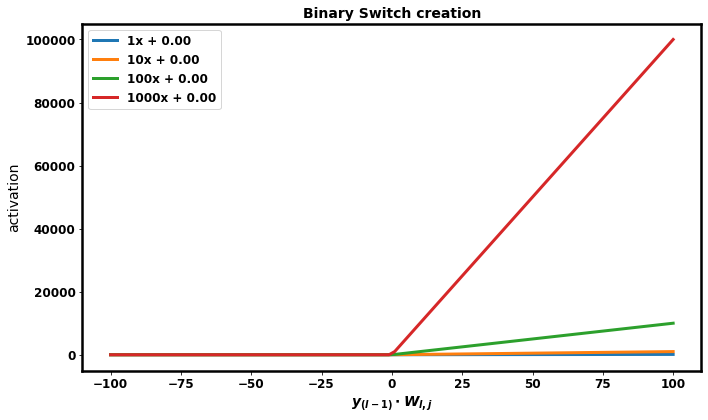

In [6]:
_ = nnh.plot_steps( [ nnh.NN(1,0), nnh.NN(10,0), nnh.NN(100,0), nnh.NN(1000,0), ])

And by varying the intercept (bias) we can shift this vertical line to any point on the feature axis.

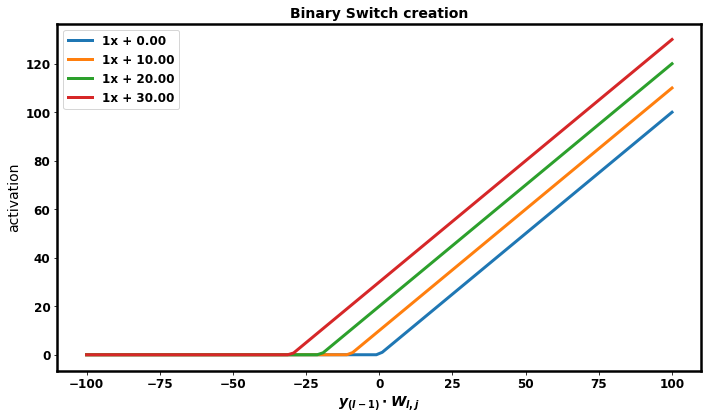

In [7]:
_ = nnh.plot_steps( [ nnh.NN(1,0), nnh.NN(1,10), nnh.NN(1,20), nnh.NN(1,30), ])

With a little effort, we can construct a neuron 
- With near infinite slope
- Rising from the x-axis at any offset.

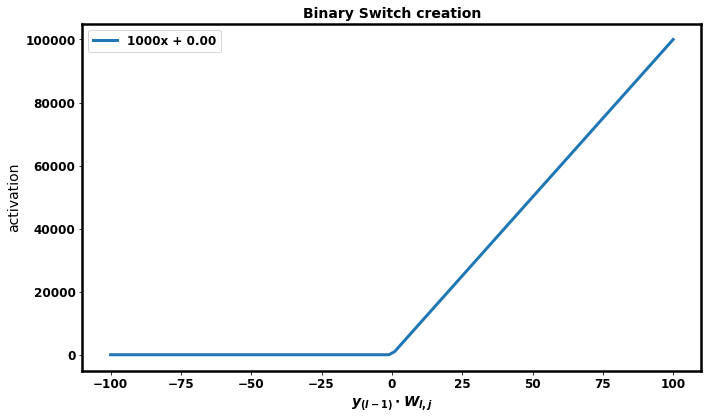

In [8]:
slope = 1000
start_offset = 0

start_step = nnh.NN(slope, -start_offset)

_= nnh.plot_steps( [  start_step ] )

We can create a second "inverted" (negative slope) neuron with intercept "epsilon" from the first neuron


In [9]:
end_offset = start_offset + .0001

end_step = nnh.NN(slope,- end_offset)


Adding the two neurons together creates a Binary Switch
- unit height
- 0 output at inputs
less than the x-intercept
- unit output for all inputs greater than the intercept).

(The sigmoid function is even more easily transformed into a step function).

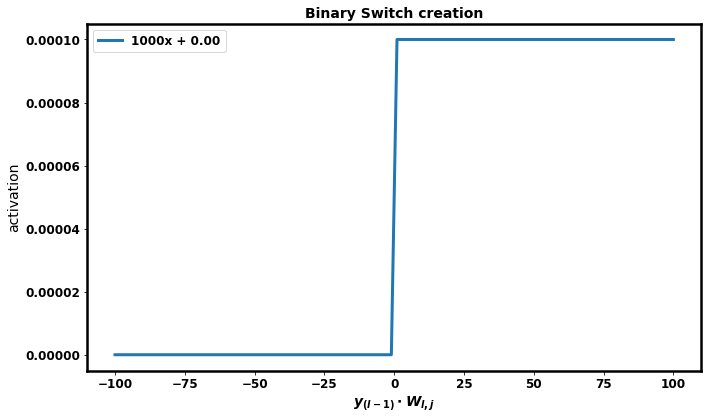

In [12]:
step= {"x": start_step["x"], 
       "y": start_step["y"] - end_step["y"],
       "W": slope,
       "b": 0
      }
_= nnh.plot_steps( [  step ] )

In [11]:
print("Done")

Done
